In [1]:
from RNN_QSR import *

cuda:0


# Reshaping the 2D sequence tensor into chunks

In [2]:
def patch(x,Lx):
    # type: (Tensor,int) -> Tensor
    """patch your sequence into chunks of 4"""
    #make the input 2D then break it into 2x2 chunks 
    #afterwards reshape the 2x2 chunks to vectors of size 4 and flatten the 2d bit
    return x.view([x.shape[0],Lx,Lx]).unfold(-2,2,2).unfold(-2,2,2).reshape([x.shape[0],Lx*Lx//4,4])

def unpatch(x,Lx):
    # type: (Tensor,int) -> Tensor
    """inverse function for patch"""
    # original sequence order can be retrieved by chunking twice more
    #in the x-direction you should have chunks of size 2, but in y it should
    #be chunks of size Ly//2
    return x.unfold(-2,Lx//2,Lx//2).unfold(-2,2,2).reshape([x.shape[0],Lx*Lx])

Lx=6
a = torch.arange(Lx**2).unsqueeze(0)
print(a)
print(a.view([Lx,Lx]))
b = patch(a,Lx)
print(b)
c = unpatch(b,Lx)
print(c)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]])
tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35]])
tensor([[[ 0,  1,  6,  7],
         [ 2,  3,  8,  9],
         [ 4,  5, 10, 11],
         [12, 13, 18, 19],
         [14, 15, 20, 21],
         [16, 17, 22, 23],
         [24, 25, 30, 31],
         [26, 27, 32, 33],
         [28, 29, 34, 35]]])
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]])


In [3]:
class PE2D(nn.Module):
    #TODO: Positional encoding is wrong because the spins are at index i+1 when we sample and get probabilities
    def __init__(self, d_model, Lx,Ly,device,n_encode=None):
        
        
        super().__init__()
        assert (d_model%4==0)
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(Lx*Ly, d_model)
        
        if type(n_encode)==type(None):
            n_encode=3*d_model//4
        for pos in range(Lx*Ly):
            x=pos//Ly
            y=pos%Ly
            # Only going to fill 3/4 of the matrix so the
            # occupation values are preserved
            for i in range(0, n_encode, 4):
                
                #x direction encoding
                pe[pos, i] = \
                math.sin(x / (10000 ** ((2 * i)/n_encode)))
                pe[pos, i + 1] = \
                math.cos(x / (10000 ** ((2 * (i + 1))/n_encode)))
                #y direction encoding
                pe[pos, i+2] = \
                math.sin(y / (10000 ** ((2 * i)/n_encode)))
                pe[pos, i + 3] = \
                math.cos(y / (10000 ** ((2 * (i + 1))/n_encode)))
                
        self.pe = pe.unsqueeze(1).to(device)
        self.L=Lx*Ly
    
    def forward(self, x):
        return x.repeat(1,1,self.d_model//4) + self.pe[:x.shape[0]]

In [4]:
@torch.jit.script
def patch2idx(patch):
    #moving the last dimension to the front
    patch=patch.unsqueeze(0).transpose(-1,0).squeeze(-1)
    out=torch.zeros(patch.shape[1:],device=patch.device)
    for i in range(4):
        out+=patch[i]<<i
    return out.to(torch.int64)

@torch.jit.script
def patch2onehot(patch):
    #moving the last dimension to the front
    patch=patch.unsqueeze(0).transpose(-1,0).squeeze(-1)
    out=torch.zeros(patch.shape[1:],device=patch.device)
    for i in range(4):
        out+=patch[i]<<i
    return nn.functional.one_hot(out.to(torch.int64), num_classes=16)

In [5]:
class PatchTransformerBase(Sampler):#(torch.jit.ScriptModule):
    """
    Base class for the two patch transformer architectures 
    
    Architexture wise this is how a patched transformer works:
    
    You give it a (2D) state and it patches it into groups of 4 (think of a 2x2 cnn filter with stride 2). It then tells you
    the probability of each patch given it and all previous patches in your sequence using masked attention.
    
    Outputs should either be size 1 (the probability of the current patch which is input) or size 16 (for 2x2 patches where 
    the probability represented is of each potential patch)
    
    """
    def __init__(self,Lx,device=device,Nh=128,dropout=0.0,num_layers=2,nhead=8,outsize=1, **kwargs):
        super(PatchTransformerBase, self).__init__()
        #print(nhead)
        self.pe = PE2D(Nh, Lx,Lx,device)
        self.device=device
        #Encoder only transformer
        #misinterperetation on encoder made it so this code does not work
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=Nh, nhead=nhead, dropout=dropout)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        
        self.lin = nn.Sequential(
                nn.Linear(Nh,Nh),
                nn.ReLU(),
                nn.Linear(Nh,outsize),
                nn.Sigmoid() if outsize==1 else nn.Softmax(dim=-1)
            )
        
        self.Lx=Lx
        self.set_mask(Lx**2//4)
        
        self.options=torch.zeros([16,4],device=self.device)
        tmp=torch.arange(16,device=self.device)
        for i in range(4):
            self.options[:,i]=(tmp>>i)%2
        
        
        self.to(device)
        
    def set_mask(self, L):
        # type: (int)
        # take the log of a lower triangular matrix
        self.L=L
        self.mask = torch.log(torch.tril(torch.ones([L,L],device=self.device)))
        self.pe.L=L
        
        
    def forward(self, input):
        # input is shape [B,L,1]
        # add positional encoding to get shape [B,L,Nh]
        if input.shape[1]//4!=self.L:
            self.set_mask(input.shape[1]//4)
        #pe should be sequence first [L,B,Nh]
        input=self.pe(patch(input.squeeze(-1),self.Lx).transpose(1,0))
        output = self.transformer(input,self.mask)
        output = self.lin(output.transpose(1,0))
        return output
    
    def next_with_cache(self,tgt,cache=None,idx=-1):
        # type: (Tensor,Optional[Tensor],int) -> Tuple[Tensor,Tensor]
        """Efficiently calculates the next output of a transformer given the input sequence and 
        cached intermediate layer encodings of the input sequence
        
        Inputs:
            tgt - Tensor of shape [L,B,1]
            cache - Tensor of shape ?
            idx - index from which to start
            
        Outputs:
            output - Tensor of shape [?,B,1]
            new_cache - Tensor of shape ?
        """
        #HMMM
        output = tgt
        new_token_cache = []
        #go through each layer and apply self attention only to the last input
        for i,layer in enumerate(self.transformer.layers):
            
            tgt=output
            #have to merge the functions into one
            src = tgt[idx:, :, :]
            mask = None if idx==-1 else self.mask[idx:]

            # self attention part
            src2 = layer.self_attn(
                src,#only do attention with the last elem of the sequence
                tgt,
                tgt,
                attn_mask=mask,  
                key_padding_mask=None,
            )[0]
            #straight from torch transformer encoder code
            src = src + layer.dropout1(src2)
            src = layer.norm1(src)
            src2 = layer.linear2(layer.dropout(layer.activation(layer.linear1(src))))
            src = src + layer.dropout2(src2)
            src = layer.norm2(src)
            #return src
            
            output = src#self.next_attn(output,layer,idx)
            new_token_cache.append(output)
            if cache is not None:
                #layers after layer 1 need to use a cache of the previous layer's output on each input
                output = torch.cat([cache[i], output], dim=0)

        #update cache with new output
        if cache is not None:
            new_cache = torch.cat([cache, torch.stack(new_token_cache, dim=0)], dim=1)
        else:
            new_cache = torch.stack(new_token_cache, dim=0)

        return output, new_cache
    
    def make_cache(self,tgt):
        output = tgt
        new_token_cache = []
        #go through each layer and apply self attention only to the last input
        for i, layer in enumerate(self.transformer.layers):
            output = layer(output,src_mask=self.mask)#self.next_attn(output,layer,0)
            new_token_cache.append(output)
        #create cache with tensor
        new_cache = torch.stack(new_token_cache, dim=0)
        return output, new_cache

In [6]:
class PatchTransformer(PatchTransformerBase):
    """Note: logprobability is not normalized 
    the cost of normalization is 16x the cost of getting un normalized labels due to the output being size 1
    
    Note: To actually make sure the probability is normalized at each step you would need to run the network on all 16 
         possible 2x2 patches at each step.
         
    This is done in sample, where you feed it your batch x 16 samples (one for each possible patch), get your probabilities
    of each patch, sum them to normalize, then sample from your distribution. Once your sample is chosen, you can just
    copy the sample that was chosen,as well as your cached self attention 15 samples / cached portions that weren't chosen.
    
    
    You probably want to add in a term which asks normalization to be 1 in training, as if this doesn't hold then the sample 
    probability and label probability will be different which is very bad.
    
    An alternate form of this network (still in production) could have 16 outputs for probability instead of 1, and
    give the probability distrubition for the nth patch when given the first n-1 patches
    
    This model would always be normalized (just use softmax on the output) but total probabilities would be a bit more
    difficult to calculate as you have to match each patch to it's respective output (of the 16 total probability outputs)
    
    """
    def __init__(self,Lx, **kwargs):
        #only important bit is that outsize = 1
        super(PatchTransformer, self).__init__(Lx,outsize=1,**kwargs)
        
    def logprobability(self,input):
        """Compute the logscale probability of a given state
            Inputs:
                input - [B,L,1] matrix of zeros and ones for ground/excited states
            Returns:
                logp - [B] size vector of logscale probability labels
        """
        total = self.forward(input)
        logp=torch.sum(torch.log(total+1e-10),dim=1).squeeze(1)
        return logp   
    
    def sample(self,B,L):
        """ Generates a set states
        Inputs:
            B (int)            - The number of states to generate in parallel
            L (int)            - The length of generated vectors
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
        """
        #length is divided by four due to patching
        L=L//4
        
        #return (torch.rand([B,L,1],device=device)<0.5).to(torch.float32)
        #Sample set will have shape [B,L,1]
        #need one extra zero batch at the start for first pred hence input is [L+1,B,1] 
        #transformers don't do batch first so to save a bunch of transpose calls 
        input = torch.zeros([L,B*16,4],device=self.device)
        #self.set_mask(L)
        batchoptions=self.options.repeat(B,1)
        cache=None
        
        normalization=torch.zeros([B],device=self.device)
        
        with torch.no_grad():
          for idx in range(L):
            
            input[idx] = batchoptions
            
            
            #pe should be sequence first [L,B,Nh]
            encoded_input = self.pe(input[:idx+1,:,:])
                        
            
            #Get transformer output
            output,cache = self.next_with_cache(encoded_input,cache)
            #check out the probability of all 16 vectors
            probs=self.lin(output[-1,:,:]).view([B,16])
            
            #get the probability sum and add it's log to the normalization 
            psum=torch.sum(probs,dim=1)
            normalization+=torch.log(psum)
            
            #sample from the probability distribution
            indices = torch.multinomial(probs/psum.unsqueeze(1),1,False).squeeze(1)
            #extract samples
            sample = self.options[indices]
            
            #set input to the sample that was actually chosen
            input[idx] = sample.view([B,1,4]).repeat(1,16,1).view([B*16,4])
            
            #set cache to the samples that are used
            #cache is shape [?,L,B*16,Nh]
            
            
            tmp = cache[:,idx].view(cache.shape[0],B,16,cache.shape[-1])
            
            tmp[:] = getcache(tmp,indices) #make sure this sets things properly
            # tmp should still be a view of cache[:,idx] (same memory)
        self.normalization = normalization
        #sample is repeated 16 times at 3rd index so we just take the first one
        return unpatch(input.view([L,B,16,4])[:,:,0].transpose(1,0),self.Lx).unsqueeze(-1)
    
@torch.jit.script
def getcachealt(oldcache,indices):
    sx,B,_,sy=oldcache.shape
    newcache = oldcache*1
    for i in range(B):
        #print(oldcache[:,i,indices[i]].shape,newcache.shape)
        newcache[:,i,:]=oldcache[:,i,indices[i]].unsqueeze(1)
    return newcache
    
    
@torch.jit.script
def getcache(oldcache,indices):
    """Supposed to take the cache at the selected index and copy it to the other 15"""
    sx,B,_,sy=oldcache.shape
    newcache = oldcache*0
    for i in range(16):
        #add the cache at position i only if it is the right index???
        tmp=(oldcache[:,:,i]*((indices==i).view(1,B,1))).view(sx,B,1,sy)
        newcache+=tmp
    return newcache

In [7]:
class PatchTransformerB(PatchTransformerBase):
    """Note: logprobability IS normalized 
    
    Architexture wise this is how it works:
    
    You give it a (2D) state and it patches it into groups of 4 (think of a 2x2 cnn filter with stride 2). It then tells you
    the probability of each potential patch given all previous patches in your sequence using masked attention.
    
    
    This model has 16 outputs, which describes the probability distrubition for the nth patch when given the first n-1 patches
    
    """
    def __init__(self,Lx,**kwargs):
        #only important bit is that outsize = 16
        super(PatchTransformerB, self).__init__(Lx,outsize=16,**kwargs)
    @torch.jit.export
    def logprobability(self,input):
        # type: (Tensor) -> Tensor
        """Compute the logscale probability of a given state
            Inputs:
                input - [B,L,1] matrix of zeros and ones for ground/excited states
            Returns:
                logp - [B] size vector of logscale probability labels
        """
        
        if input.shape[1]//4!=self.L:
            self.set_mask(input.shape[1]//4)
        #pe should be sequence first [L,B,Nh]
        
        #shape is modified to [L//4,B,4]
        input = patch(input.squeeze(-1),self.Lx).transpose(1,0)
        
        data=torch.zeros(input.shape,device=self.device)
        data[1:]=input[:-1]
        
        #[L//4,B,4] -> [L//4,B,Nh]
        encoded=self.pe(data)
        #shape is preserved
        output = self.transformer(encoded,self.mask)
        # [L//4,B,Nh] -> [L//4,B,16]
        output = self.lin(output)
        
        #real is going to be a onehot with the index of the appropriate patch set to 1
        #shape will be [L//4,B,16]
        real=patch2onehot(input)
        
        #[L//4,B,16] -> [L//4,B]
        total = torch.sum(real*output,dim=-1)
        #[L//4,B] -> [B]
        logp=torch.sum(torch.log(total+1e-10),dim=0)
        return logp   
    
    @torch.jit.export
    def sample(self,B,L,cache=None):
        # type: (int,int,Optional[Tensor]) -> Tensor
        """ Generates a set states
        Inputs:
            B (int)            - The number of states to generate in parallel
            L (int)            - The length of generated vectors
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
        """
        #length is divided by four due to patching
        L=L//4
        
        #return (torch.rand([B,L,1],device=device)<0.5).to(torch.float32)
        #Sample set will have shape [B,L,1]
        #need one extra zero batch at the start for first pred hence input is [L+1,B,1] 
        input = torch.zeros([L+1,B,4],device=self.device)
         
        with torch.no_grad():
          for idx in range(1,L+1):
            
            #pe should be sequence first [L,B,Nh]
            encoded_input = self.pe(input[:idx,:,:])
                        
            #Get transformer output
            output,cache = self.next_with_cache(encoded_input,cache)
            #check out the probability of all 16 vectors
            probs=self.lin(output[-1,:,:]).view([B,16])

            #sample from the probability distribution
            indices = torch.multinomial(probs,1,False).squeeze(1)
            #extract samples
            sample = self.options[indices]
            
            #set input to the sample that was actually chosen
            input[idx] = sample
            
        #remove the leading zero in the input    
        input=input[1:]
        #sample is repeated 16 times at 3rd index so we just take the first one
        return unpatch(input.transpose(1,0),self.Lx).unsqueeze(-1)
    
    
    @torch.jit.export
    def _off_diag_labels(self,sample,B,L,grad,D=1):
        # type: (Tensor,int,int,bool,int) -> Tuple[Tensor, Tensor]
        """label all of the flipped states  - set D as high as possible without it slowing down runtime
        Parameters:
            sample - [B,L,1] matrix of zeros and ones for ground/excited states
            B,L (int) - batch size and sequence length
            D (int) - Number of partitions sequence-wise. We must have L%D==0 (D divides L)
            
        Outputs:
            
            sample - same as input
            probs - [B,L] matrix of probabilities of states with the jth excitation flipped
        """
        
        
        
        sample0=sample
        #sample is batch first at the moment
        sample = patch(sample.squeeze(-1),self.Lx)
        
        sflip = torch.zeros([B,L,L//4,4],device=self.device)
        #collect all of the flipped states into one array
        for j in range(L//4):
            #have to change the order of in which states are flipped for the cache to be useful
            for j2 in range(4):
                sflip[:,j*4+j2] = sample*1.0
                sflip[:,j*4+j2,j,j2] = 1-sflip[:,j*4+j2,j,j2]
            
        #switch sample into sequence-first
        sample = sample.transpose(1,0)
            
        #compute all of their logscale probabilities
        with torch.no_grad():
            

            data=torch.zeros(sample.shape,device=self.device)
            data[1:]=sample[:-1]
            
            #[L//4,B,4] -> [L//4,B,Nh]
            encoded=self.pe(data)
            
            #add positional encoding and make the cache
            out,cache=self.make_cache(encoded)

            probs=torch.zeros([B,L],device=self.device)
            #expand cache to group L//D flipped states
            cache=cache.unsqueeze(2)

            #this line took like 1 hour to write I'm so sad
            #the cache has to be shaped such that the batch parts line up
                        
            cache=cache.repeat(1,1,L//D,1,1).transpose(2,3).reshape(cache.shape[0],L//4,B*L//D,cache.shape[-1])

            pred0 = self.lin(out)
            #shape will be [L//4,B,16]
            real=patch2onehot(sample)
            #[L//4,B,16] -> [B,L//4]
            total0 = torch.sum(real*pred0,dim=-1).transpose(1,0)

            for k in range(D):

                N = k*L//D
                #next couple of steps are crucial          
                #get the samples from N to N+L//D
                #Note: samples are the same as the original up to the Nth spin
                real = sflip[:,N:(k+1)*L//D]
                #flatten it out and set to sequence first
                tmp = real.reshape([B*L//D,L//4,4]).transpose(1,0)
                #set up next state predction
                fsample=torch.zeros(tmp.shape,device=self.device)
                fsample[1:]=tmp[:-1]
                # put sequence before batch so you can use it with your transformer
                tgt=self.pe(fsample)
                #grab your transformer output
                out,_=self.next_with_cache(tgt,cache[:,:N//4],N//4)

                # grab output for the new part
                output = self.lin(out[N//4:].transpose(1,0))
                # reshape output separating batch from spin flip grouping
                pred = output.view([B,L//D,(L-N)//4,16])
                real = patch2onehot(real[:,:,N//4:])
                total = torch.sum(real*pred,dim=-1)
                #sum across the sequence for probabilities
                
                #print(total.shape,total0.shape)
                logp=torch.sum(torch.log(total+1e-10),dim=-1)
                logp+=torch.sum(torch.log(total0[:,:N//4]+1e-10),dim=-1).unsqueeze(-1)
                probs[:,N:(k+1)*L//D]=logp
                
        return sample0,probs
    @torch.jit.export
    def sample_with_labelsALT(self,B,L,grad=False,nloops=1):
        # type: (int,int,bool,int) -> Tuple[Tensor,Tensor,Tensor]
        sample,probs = self.sample_with_labels(B,L,grad,nloops)
        logsqrtp=probs.mean(dim=1)/2
        sumsqrtp = torch.exp(probs/2-logsqrtp.unsqueeze(1)).sum(dim=1)
        return sample,sumsqrtp,logsqrtp
    @torch.jit.export
    def sample_with_labels(self,B,L,grad=False,nloops=1):
        # type: (int,int,bool,int) -> Tuple[Tensor,Tensor]
        sample=self.sample(B,L,None)
        return self._off_diag_labels(sample,B,L,grad,nloops)


In [8]:
class PatchedRNN(Sampler):
    TYPES={"GRU":nn.GRU,"ELMAN":nn.RNN,"LSTM":nn.LSTM}
    def __init__(self,Lx,rnntype="GRU",Nh=128,device=device, **kwargs):
        super(PatchedRNN, self).__init__(device=device)
        
        
        assert rnntype!="LSTM"
        #rnn takes input shape [B,L,1]
        self.rnn = RNN.TYPES[rnntype](input_size=4,hidden_size=Nh,batch_first=True)
        
        
        self.lin = nn.Sequential(
                nn.Linear(Nh,Nh),
                nn.ReLU(),
                nn.Linear(Nh,16),
                nn.Softmax(dim=-1)
            )
        self.Nh=Nh
        self.rnntype=rnntype
        
        
        self.Lx=Lx
        self.L = (Lx**2//4)
        
        self.options=torch.zeros([16,4],device=self.device)
        tmp=torch.arange(16,device=self.device)
        for i in range(4):
            self.options[:,i]=(tmp>>i)%2
            
        
        self.to(device)
    def forward(self, input):
        # h0 is shape [d*numlayers,B,H] but D=numlayers=1 so
        # h0 has shape [1,B,H]
        
        #if self.rnntype=="LSTM":
        #    h0=[torch.zeros([1,input.shape[0],self.Nh],device=self.device),
        #       torch.zeros([1,input.shape[0],self.Nh],device=self.device)]
            #h0 and c0
        #else:
        h0=torch.zeros([1,input.shape[0],self.Nh],device=self.device)
        out,h=self.rnn(input,h0)
        return self.lin(out)
    
    @torch.jit.export
    def logprobability(self,input):
        # type: (Tensor) -> Tensor
        """Compute the logscale probability of a given state
            Inputs:
                input - [B,L,1] matrix of zeros and ones for ground/excited states
            Returns:
                logp - [B] size vector of logscale probability labels
        """
                
        #shape is modified to [B,L//4,4]
        input = patch(input.squeeze(-1),self.Lx)
        data=torch.zeros(input.shape,device=self.device)
        #batch first
        data[:,1:]=input[:,:-1]
        # [B,L//4,Nh] -> [B,L//4,16]
        output = self.forward(data)
        
        #real is going to be a onehot with the index of the appropriate patch set to 1
        #shape will be [B,L//4,16]
        real=patch2onehot(input)
        
        #[B,L//4,16] -> [B,L//4]
        total = torch.sum(real*output,dim=-1)
        #[B,L//4] -> [B]
        logp=torch.sum(torch.log(total+1e-10),dim=1)
        return logp
    @torch.jit.export
    def sample(self,B,L,cache=None):
        # type: (int,int,Optional[Tensor]) -> Tensor
        """ Generates a set states
        Inputs:
            B (int)            - The number of states to generate in parallel
            L (int)            - The length of generated vectors
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
        """
        #length is divided by four due to patching
        L=L//4
        #if self.rnntype=="LSTM":
        #    h=[torch.zeros([1,B,self.Nh],device=self.device),
        #       torch.zeros([1,B,self.Nh],device=self.device)]
            #h is h0 and c0
        #else:
        h=torch.zeros([1,B,self.Nh],device=self.device)
        #Sample set will have shape [B,L,4]
        #need one extra zero batch at the start for first pred hence input is [L+1,B,1] 
        input = torch.zeros([B,L+1,4],device=self.device)
         
        with torch.no_grad():
          for idx in range(1,L+1):
            #out should be batch first [B,L,Nh]
            out,h=self.rnn(input[:,idx-1:idx,:],h)
            #check out the probability of all 16 vectors
            probs=self.lin(out[:,0,:]).view([B,16])
            #sample from the probability distribution
            indices = torch.multinomial(probs,1,False).squeeze(1)
            #extract samples
            sample = self.options[indices]
            #set input to the sample that was actually chosen
            input[:,idx] = sample
        #remove the leading zero in the input    
        #sample is repeated 16 times at 3rd index so we just take the first one
        return unpatch(input[:,1:],self.Lx).unsqueeze(-1)
    
    @torch.jit.export
    def sample_with_labelsALT(self,B,L,grad=False,nloops=1):
        # type: (int,int,bool,int) -> Tuple[Tensor,Tensor,Tensor]
        sample,probs = self.sample_with_labels(B,L,grad,nloops)
        logsqrtp=probs.mean(dim=1)/2
        sumsqrtp = torch.exp(probs/2-logsqrtp.unsqueeze(1)).sum(dim=1)
        return sample,sumsqrtp,logsqrtp
    @torch.jit.export
    def sample_with_labels(self,B,L,grad=False,nloops=1):
        # type: (int,int,bool,int) -> Tuple[Tensor,Tensor]
        sample=self.sample(B,L,None)
        return self._off_diag_labels(sample,B,L,grad,nloops)
    
    
    @torch.jit.export
    def _off_diag_labels(self,sample,B,L,grad,D=1):
        # type: (Tensor,int,int,bool,int) -> Tuple[Tensor, Tensor]
        """label all of the flipped states  - set D as high as possible without it slowing down runtime
        Parameters:
            sample - [B,L,1] matrix of zeros and ones for ground/excited states
            B,L (int) - batch size and sequence length
            D (int) - Number of partitions sequence-wise. We must have L%D==0 (D divides L)
            
        Outputs:
            
            sample - same as input
            probs - [B,L] matrix of probabilities of states with the jth excitation flipped
        """
        sample0=sample
        #sample is batch first at the moment
        sample = patch(sample.squeeze(-1),self.Lx)
        
        sflip = torch.zeros([B,L,L//4,4],device=self.device)
        #collect all of the flipped states into one array
        for j in range(L//4):
            #have to change the order of in which states are flipped for the cache to be useful
            for j2 in range(4):
                sflip[:,j*4+j2] = sample*1.0
                sflip[:,j*4+j2,j,j2] = 1-sflip[:,j*4+j2,j,j2]
            
        #compute all of their logscale probabilities
        with torch.no_grad():
            
            data=torch.zeros(sample.shape,device=self.device)
            
            data[:,1:]=sample[:,:-1]
            
            #add positional encoding and make the cache
            
            h=torch.zeros([1,B,self.Nh],device=self.device)
            
            out,_=self.rnn(data,h)
            
            #cache for the rnn is the output in this sense
            #shape [B,L//4,Nh]
            cache=out
            probs=torch.zeros([B,L],device=self.device)
            #expand cache to group L//D flipped states
            cache=cache.unsqueeze(1)

            #this line took like 1 hour to write I'm so sad
            #the cache has to be shaped such that the batch parts line up
                        
            cache=cache.repeat(1,L//D,1,1).reshape(B*L//D,L//4,cache.shape[-1])
                        
            pred0 = self.lin(out)
            #shape will be [B,L//4,16]
            real=patch2onehot(sample)
            #[B,L//4,16] -> [B,L//4]
            total0 = torch.sum(real*pred0,dim=-1)

            for k in range(D):

                N = k*L//D
                #next couple of steps are crucial          
                #get the samples from N to N+L//D
                #Note: samples are the same as the original up to the Nth spin
                real = sflip[:,N:(k+1)*L//D]
                #flatten it out and set to sequence first
                tmp = real.reshape([B*L//D,L//4,4])
                #set up next state predction
                fsample=torch.zeros(tmp.shape,device=self.device)
                fsample[:,1:]=tmp[:,:-1]
                #grab your rnn output
                if k==0:
                    out,_=self.rnn(fsample,cache[:,0].unsqueeze(0)*0.0)
                else:
                    out,_=self.rnn(fsample[:,N//4:],cache[:,N//4-1].unsqueeze(0)*1.0)
                # grab output for the new part
                output = self.lin(out)
                # reshape output separating batch from spin flip grouping
                pred = output.view([B,L//D,(L-N)//4,16])
                real = patch2onehot(real[:,:,N//4:])
                total = torch.sum(real*pred,dim=-1)
                #sum across the sequence for probabilities
                #print(total.shape,total0.shape)
                logp=torch.sum(torch.log(total+1e-10),dim=-1)
                logp+=torch.sum(torch.log(total0[:,:N//4]+1e-10),dim=-1).unsqueeze(-1)
                probs[:,N:(k+1)*L//D]=logp
                
        return sample0,probs

In [9]:
p = PatchTransformer(4)

# Testing torch multinomial

In [10]:
B=8
batchoptions=p.options.repeat(B,1)
sm = batchoptions.reshape([B,16,4])
probs = torch.rand([B,16],device=device)
#get the probability sum and add it's log to the normalization 
psum=torch.sum(probs,dim=1).unsqueeze(1)

indices = torch.multinomial(probs/psum,1,False)

print(indices.squeeze(1))

print(p.options[indices.squeeze(1)].shape)

tensor([12,  9,  5,  4,  0,  2, 15,  1], device='cuda:0')
torch.Size([8, 4])


In [11]:
x = torch.zeros([4,8,16,3],device=device)

print(getcache(x,indices.squeeze(1)).shape)

print(getcachealt(x,indices.squeeze(1)).shape)

torch.Size([4, 8, 16, 3])
torch.Size([4, 8, 16, 3])


# Testing getcache functions

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       device='cuda:0')


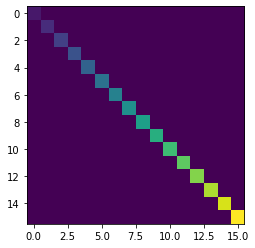

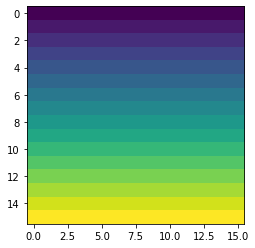

In [12]:
tst = (torch.eye(16)*(torch.arange(16)+1)).to(device)

indices2=torch.arange(16,device=device)
print(indices2)
plt.imshow(tst.cpu())
plt.show()
plt.imshow(getcache(tst.view([1,16,16,1]),indices2).view([16,16]).cpu())
plt.show()

In [13]:
p.sample(8,4*4).shape

torch.Size([8, 16, 1])

In [14]:
p.logprobability(p.sample(8,4*4)).shape

torch.Size([8])

In [15]:
x=torch.zeros([1,2,3,4])
x.transpose(-1,0).shape

torch.Size([4, 2, 3, 1])

In [16]:
print(patch2idx(p.options))

print((p.options[patch2idx(p.options)]==p.options))

print(patch2onehot(p.options))

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       device='cuda:0')
tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]], device='cuda:0')
tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

In [17]:
pb = PatchedRNN(8)

pb.logprobability(pb.sample(12,8*8)).shape

torch.Size([12])

In [18]:
12*64

768

In [19]:
def get_indices(Lx):
    sflip = torch.arange(Lx*Lx,device=device).to(torch.int64).reshape([1,Lx,Lx])
    sflip = patch(sflip,Lx).reshape(Lx*Lx)
    
    return sflip

In [20]:
get_indices(4)

tensor([ 0,  1,  4,  5,  2,  3,  6,  7,  8,  9, 12, 13, 10, 11, 14, 15],
       device='cuda:0')

1.7639249563217163e-05 0.21736802653215292
tensor(-44.3169, device='cuda:0') tensor(-44.3169, device='cuda:0')
tensor(0.0001, device='cuda:0')


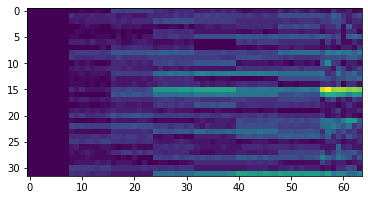

In [21]:
if True:
    B=32

    s = pb.sample(B,8*8)
    probs = super(PatchedRNN,pb)._off_diag_labels(s,B,8*8,False,D=8)[1][:,get_indices(8)]
    
    p2 = pb._off_diag_labels(s,B,8*8,False,D=8)[1]

    print(abs(probs-p2).mean().item(),torch.var_mean(probs)[0].item()**0.5)
    print(probs.mean(),p2.mean())
    print(abs(probs-p2).max())
    plt.imshow(abs(probs-p2).cpu())

In [22]:
op=Opt()
Lx=32
op.L=Lx*Lx
op.Nh=128
op.lr=5e-4
op.M=0.9
op.Q=4
op.K=64
op.USEQUEUE=0
op.kl=0.0
#op.apply(sys.argv[1:])
op.B=op.K*op.Q

#op.steps=4000
op.dir="PTF"
#op.steps=100
op.NLOOPS=256
print(op)

L                             			1024
Q                             			4
K                             			64
B                             			256
TOL                           			0.15
M                             			0.9
USEQUEUE                      			0
NLOOPS                        			256
hamiltonian                   			Rydberg
steps                         			12000
dir                           			PTF
Nh                            			128
lr                            			0.0005
kl                            			0.0



In [23]:
#os.system("python Patched_TF.py "+op.cmd())


In [24]:
trainsformer = torch.jit.script(PatchTransformerB(Lx,Nh=op.Nh,num_layers=2))

#trainsformer = torch.jit.script(PatchedRNN(Lx,Nh=op.Nh))
#trainsformer = RNN(Nh=op.Nh)
#sampleformer= PatchedRNN(Lx,Nh=op.Nh)

beta1=0.9;beta2=0.999
optimizer = torch.optim.Adam(
trainsformer.parameters(), 
lr=op.lr, 
betas=(beta1,beta2)
)

C:\Users\sprag\anaconda3\envs\pytorch\lib\site-packages\torch\jit\_recursive.py:229: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  "Consider removing it.".format(name))


In [25]:
if op.USEQUEUE:
    queue_train(op,(trainsformer,sampleformer,optimizer))
else:
    print("Training. . .")
    reg_train(op,(trainsformer,optimizer))

Training. . .
Output folder path established
-0.3687 1024
17,2.70|11095,-0.33|18837,-0.33|26579,-0.34|34319,-0.34|42066,-0.37|54534,-0.37|69547,-0.37|81270,-0.37|

In [26]:
1/0

ZeroDivisionError: division by zero

# Test Class for the patch transformer which makes sure all probabilities are consistent

In [ ]:
class testPTF(PatchTransformerB):
    """Just adds some functions which make sure all probability labels are consistent"""
    def __init__(self,Lx,**kwargs):
        super(testPTF,self).__init__(Lx,**kwargs)
        self.reset(1)
#functions below aren't really necessary anymore since there was no issue with masking (they serve to avoid using a mask)
    def reset(self,B):
        # type: (int) -> Tensor
        """Setup for an autoregressive transformer"""
        self._input = torch.zeros([self.L+1,B,4],device=self.device)
        self._i=1
        encoded_input = self.pe(self._input[:self._i,:,:])
        output,self._cache = self.next_with_cache(encoded_input,None)
        probs=self.lin(output[-1,:,:])
        return probs
    def getnext(self,vect):
        # type: (Tensor) -> Tensor
        """Get probability for the next output in an autoregressive transformer"""
        self._input[self._i]=vect
        self._i+=1
        encoded_input = self.pe(self._input[:self._i,:,:])
        output,self._cache = self.next_with_cache(encoded_input,self._cache)
        probs=self.lin(output[-1,:,:])
        return probs
    @torch.jit.export
    def testsample(self,B):
        # type: (int) -> Tuple[Tensor,Tensor]
        """Generate states with their probabilities in logscale"""
        #set up variables
        L=self.L
        probs=self.reset(B).squeeze(0)
        sprobs=torch.zeros([B],device=self.device)
        samples = torch.zeros([B,L,4],device=self.device)
        with torch.no_grad():
          for idx in range(L):
            #loop through L sequence elements and generate next in sequence based off of probabilities
            #sample from the probability distribution
            indices = torch.multinomial(probs,1,False).squeeze(1)
            #extract samples
            sample = self.options[indices]
            #set input to the sample that was actually chosen
            samples[:,idx] = sample
            real=patch2onehot(sample)
            total = torch.sum(real*probs,dim=-1)
            sprobs+=torch.log(total)
            if idx!=L-1: probs = self.getnext(sample)
                
        return unpatch(samples,self.Lx).unsqueeze(-1),sprobs
    
    @torch.jit.export
    def testlabels(self,samples,B):
        # type: (Tensor,int) -> Tuple[Tensor,Tensor]
        """Get logscale probabilities of all states with one spin flipped at position j"""
        with torch.no_grad():
            #print("|",end="")
            L=self.L
            orig=samples
            samples=patch(samples.squeeze(-1),self.Lx)
            
            logprobs=torch.zeros([B,L*4],device=self.device)
            for k in range(L*4):
                #loop cross L flipped states (batched)
                probs=self.reset(B).squeeze(0)
                sprobs = torch.zeros([B],device=self.device)
                #loop across sequence
                for idx in range(L):
                    
                    sample = samples[:,idx] 
                    #kth state is flipped
                    if idx==k//4:
                        #multiply by 1 as a way to copy the tensor to new memory
                        sample=sample*1.0
                        sample[:,k%4] = 1-sample[:,k%4]
                    real=patch2onehot(sample)
                    sprobs+=torch.log(torch.sum(real*probs,dim=-1))
                    if idx!=L-1: probs = self.getnext(sample)
                logprobs[:,k]=sprobs
        return orig,logprobs

In [ ]:
#mydir = setup_dir(op)
#mydir = "PTF/Rydberg/64-NoQ-B=128-K=128-Nh=128-kl=0.00/0"#
mydir = "PTF/Rydberg/576-NoQ-B=256-K=256-Nh=128-kl=0.00/0"

op.L=576
Lx=24
tst=torch.jit.load(mydir+"/T")

In [ ]:
tesTF = testPTF(24,Nh=op.Nh,num_layers=2)
tesTF = torch.jit.script(tesTF)
momentum_update(0,tesTF,tst)

In [ ]:
if tesTF.Lx==8:
    s,p = tesTF.testsample(8)

    print(p)
    print(tesTF.logprobability(s))

    s2,p2=tesTF.testlabels(s,8)



    s3,p3=tesTF._off_diag_labels(s,8,64,False,1)

    print(s.shape,s2.shape,p2.shape,p3.shape)

    print(torch.sum(p3,dim=-1)/64)
    print(torch.sum(p2,dim=-1)/64)

In [ ]:
op.K=256
op.Q=32
op.B=op.K*op.Q



# Hamiltonian parameters
N = op.L   # Total number of atoms
V = 7.0     # Strength of Van der Waals interaction
Omega = 1.0 # Rabi frequency
delta = 1.0 # Detuning 

if op.hamiltonian=="Rydberg":
    Lx=Ly=int(op.L**0.5)
    op.L=Lx*Ly
    h = Rydberg(Lx,Ly,V,Omega,delta)
else:
    #hope for the best here since there aren't defaults
    h = TFIM(op.L,op.h,op.J)


E_queue = torch.zeros([op.B],device=device)
def fill_queue(net):
    for i in range(op.Q):
        print("|",end="")
        if False:
            sample,lp = net.testsample(op.K)
            _,probs= net.testlabels(sample,op.K)
            sqrtp=probs.mean(dim=1)/2
            sump = torch.exp(probs/2-sqrtp.unsqueeze(1)).sum(dim=1)  
        else:
            sample,sump,sqrtp = net.sample_with_labelsALT(op.K,op.L,grad=False,nloops=144)
            with torch.no_grad():
                lp=net.logprobability(sample)
                
        with torch.no_grad():
            E_i=h.localenergyALT(sample,lp,sump,sqrtp)
            E_queue[i*op.K:(i+1)*op.K]=E_i
t=time.time()
fill_queue(tesTF)
print(time.time()-t)

In [ ]:
def errformat(m,s):
    exp = -int(np.floor(np.log(s)/np.log(10)))
    print( str(round(m,exp))+" +/- "+str(round(s,exp)))

var,mean = torch.var_mean(E_queue/op.L)

print(h.ground(),op.B)
stdv=((var/op.B)**0.5).item()
errformat(mean.item(),stdv)